In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
import math

from bisect import bisect_left
from bokeh.plotting import figure,show,output_notebook
from datetime import datetime
import xgboost as xgb
from bokeh.models import Range1d
from datetime import date

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import grid_search
from sklearn import cross_validation, metrics as mtrcs
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler,Nystroem
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

from sklearn.svm import SVC

import holidays

sns.set_style("white")
sns.set_context("poster",font_scale=1.1)
output_notebook()
%matplotlib inline

BokehJS successfully loaded.

In [2]:
878049+884262

1762311

In [3]:
## get data

#train = pd.read_csv('..Data/train.csv')
#test = pd.read_csv('..Data/test.csv')

train = pd.read_csv('/home/ubuntu/Data/train.csv')
test = pd.read_csv('/home/ubuntu/Data/test.csv')

print 'train',len(train)
print 'test',len(test)

train['Id'] = train.index.values
train['Id'] = train['Id'].apply(lambda x:(884262+x))
train = train.set_index('Id',drop=True)
test = test.set_index('Id',drop=True)


train.info()
train.head()

train 878049
test 884262
<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 884262 to 1762310
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
Id,,,,,,,,,
884262,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
884263,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
884264,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
884265,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
884266,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
## make text readable
 
train.loc[:,'Category'] = train['Category'].apply(lambda x: x.title())
train.loc[:,'Descript'] = train['Descript'].apply(lambda x: x.title())
train.loc[:,'Resolution'] = train['Resolution'].apply(lambda x: x.title())

Baseline 0.0


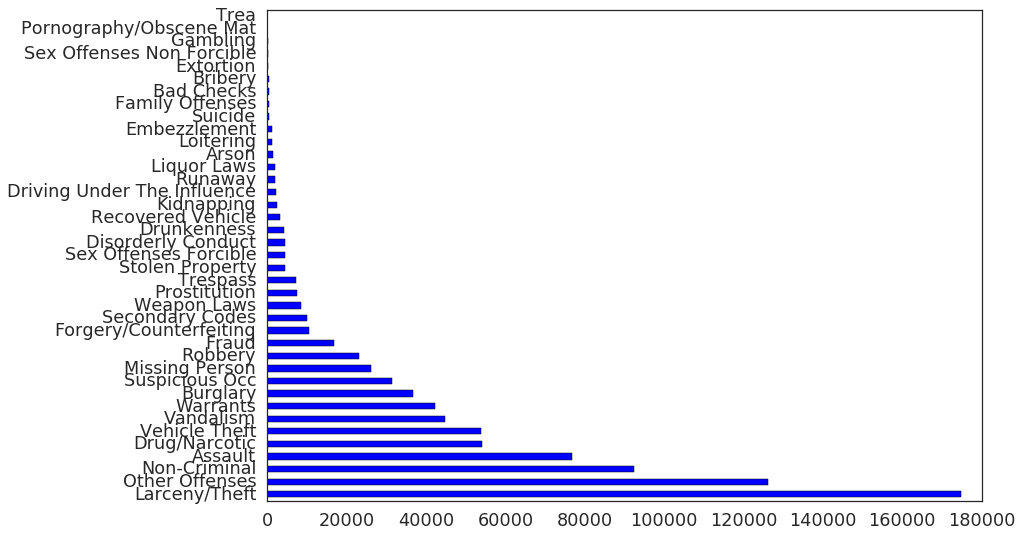

In [5]:
## plot value counts of Category

sns.set_style("white")
sns.set_context("poster",font_scale=1.1)

print "Baseline",len(train[train.Category=='Larcent/Theft'])/float(len(train))

train.Category.value_counts().plot(kind='barh')

In [6]:
## combine train and test data 

traind = train.drop(['Category','Descript','Resolution'],axis=1)

traind = traind[test.columns]

train_index = train.index.values
test_index = test.index.values

all_crimes = pd.concat([traind,test],ignore_index=0)
all_crimes.info()
all_crimes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762311 entries, 884262 to 884261
Data columns (total 6 columns):
Dates         object
DayOfWeek     object
PdDistrict    object
Address       object
X             float64
Y             float64
dtypes: float64(2), object(4)
memory usage: 94.1+ MB


,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
884262,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
884263,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
884264,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414
884265,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873
884266,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
## error coding on Y

# avg Y for PD district

y_by_district = all_crimes.groupby('PdDistrict').Y.mean()

all_crimes['Y'][all_crimes.Y==90] = all_crimes['PdDistrict'][all_crimes.Y==90].map(y_by_district)

# convert Dates to datetime64
all_crimes['Dates'] = pd.to_datetime(all_crimes['Dates'],format='%Y-%m-%d %H:%M:%S',errors='raise')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
## feature engineering for dates

# date extraction

all_crimes['Year'] = all_crimes['Dates'].dt.year
all_crimes['Month'] = all_crimes['Dates'].dt.month
all_crimes['Day'] = all_crimes['Dates'].dt.day
all_crimes['Hour'] = all_crimes['Dates'].dt.hour
all_crimes['Minute'] = all_crimes['Dates'].dt.minute
all_crimes['Weekday'] = all_crimes['Dates'].dt.weekday

# concatenate to get more time movements

all_crimes['Year-Month'] = all_crimes['Year'].map(str) + '-' + all_crimes['Month'].map(str)
all_crimes['Month-Day'] = all_crimes['Month'].map(str) + '-' + all_crimes['Day'].map(str)
all_crimes['Day-Hour'] = all_crimes['Day'].map(str) + '-' + all_crimes['Hour'].map(str)

# isweekend

def IsWeekend(day):
    if day in [5,6]:
        return 1
    return 0

all_crimes['IsWeekend'] = all_crimes['Weekday'].apply(IsWeekend)   
    
    
# season    
    
def Season(d):
    if d in [12,1,2]:
        return "Winter"
    elif d in [3,4,5]:
        return "Spring"
    elif d in [6,7,8]:
        return "Summer"
    elif d in [9,10,11]:
        return "Fall"

all_crimes['Season'] = all_crimes['Month'].apply(Season) 


In [9]:
## feature creation on address

# street type

convert_st = {'AY':'WY','80':'HY','ER':'TR','MS':'AV',
              'AR':'BL','EX':'AV','RK':'ST','WK':'ST',
              'RW':'ST',' /':'ST','NO':'ST','TI':'ST'}

def StreetType(s):
    if '/' in s:
        return 'CNR'
    
    slc = s[-2:]
    
    if slc in convert_st.keys():
        return convert_st[slc]
    return s[-2:]

all_crimes['street_type'] = all_crimes['Address'].apply(StreetType)

# street name

def StreetName(s):
    if '/' in s:
        return 'CORNER'
    return s.split()[-2]
    
#all_crimes['street_name'] = all_crimes['Address'].apply(StreetName)

def IsCorner(s):
    if "/" in s:
        return 1
    return 0

all_crimes['IsCorner'] = all_crimes['Address'].apply(IsCorner)





In [10]:
## feature creation on coordinates

# convert to polar coordinates

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

all_crimes[['rho','phi']] = all_crimes[['X','Y']].apply(lambda (x,y):list(cart2pol(x, y)),axis=1)

# rotate coordinates

def rotate(x, y,t):
    xr = x*np.cos(t) - y*np.sin(t)
    yr = y*np.cos(t) + x*np.sin(t)
    return (xr,yr)

all_crimes[['X_30','Y_30']] = all_crimes[['X','Y']].apply(lambda (x,y):list(rotate(x, y,30)),axis=1)
all_crimes[['X_60','Y_60']] = all_crimes[['X','Y']].apply(lambda (x,y):list(rotate(x, y,45)),axis=1)
all_crimes[['X_90','Y_90']] = all_crimes[['X','Y']].apply(lambda (x,y):list(rotate(x, y,60)),axis=1)


In [11]:
### plot tableau

# crms = ['Arson', 'Assault', 'Bad Checks', 'Bribery', 'Burglary',
#        'Disorderly Conduct', 'Driving Under The Influence',
#        'Drug/Narcotic', 'Drunkenness', 'Embezzlement', 'Extortion',
#        'Family Offenses', 'Forgery/Counterfeiting', 'Fraud', 'Gambling',
#        'Kidnapping', 'Larceny/Theft', 'Liquor Laws', 'Loitering',
#        'Missing Person', 'Non-Criminal', 'Other Offenses',
#        'Pornography/Obscene Mat', 'Prostitution', 'Recovered Vehicle',
#        'Robbery', 'Runaway', 'Secondary Codes', 'Sex Offenses Forcible',
#        'Sex Offenses Non Forcible', 'Stolen Property', 'Suicide',
#        'Suspicious Occ', 'Trea', 'Trespass', 'Vandalism', 'Vehicle Theft',
#        'Warrants', 'Weapon Laws']


#plot_tableau = all_crimes.ix[train_index].join(train[['Category','Descript','Resolution']])
# plot_tableau.head()


# violent_crimes = ['Murder','Assault','']

In [12]:
# # crime type and is_corner

# sns.set_style("white")

# sns.set_context("poster",font_scale=1.1)

# measure = 'is_corner'

# plot_tableau.groupby('Category')[measure].mean().plot(title=measure,kind='barh',color='darksalmon')


In [13]:
all_crimes.head(3)

,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,Day,Hour,...,street_type,IsCorner,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,,,,,,,,,,,
884262,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,...,CNR,1,128.121112,2.842310,18.438127,126.787439,-96.455552,-84.328795,128.114107,1.339694
884263,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,...,CNR,1,128.121112,2.842310,18.438127,126.787439,-96.455552,-84.328795,128.114107,1.339694
884264,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,...,CNR,1,128.127265,2.842114,18.463869,126.789911,-96.476716,-84.313933,128.120520,1.314641


# Model Building

### Prepare data for model

In [14]:
all_crimes.drop(['DayOfWeek','Address'],axis=1,inplace=True)

In [15]:
all_crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762311 entries, 884262 to 884261
Data columns (total 25 columns):
Dates          datetime64[ns]
PdDistrict     object
X              float64
Y              float64
Year           int64
Month          int64
Day            int64
Hour           int64
Minute         int64
Weekday        int64
Year-Month     object
Month-Day      object
Day-Hour       object
IsWeekend      int64
Season         object
street_type    object
IsCorner       int64
rho            float64
phi            float64
X_30           float64
Y_30           float64
X_60           float64
Y_60           float64
X_90           float64
Y_90           float64
dtypes: datetime64[ns](1), float64(10), int64(8), object(6)
memory usage: 349.6+ MB


In [16]:
cat_cols = []
cont_cols = []


for col in all_crimes:
    if (all_crimes[col].dtypes == 'int64') or (all_crimes[col].dtypes == 'object'):
        cat_cols.append(col)
    elif all_crimes[col].dtypes == 'float64':
        cont_cols.append(col)

print cat_cols
print cont_cols

['PdDistrict', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Weekday', 'Year-Month', 'Month-Day', 'Day-Hour', 'IsWeekend', 'Season', 'street_type', 'IsCorner']
['X', 'Y', 'rho', 'phi', 'X_30', 'Y_30', 'X_60', 'Y_60', 'X_90', 'Y_90']


In [17]:
## scale continuous columns

scaler = StandardScaler()

cat_df = all_crimes[cat_cols]
cont_df = all_crimes[cont_cols]
x_cont = scaler.fit_transform(cont_df)
X_cont = pd.DataFrame(x_cont, columns=cont_df.columns,index=cont_df.index)
X_cont.head()

,X,Y,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,
884262,-0.105527,0.313876,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884263,-0.105527,0.313876,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884264,-0.055688,1.381871,0.392593,-1.213171,1.312554,0.227636,-1.200538,0.528129,0.404627,-1.205874
884265,-0.141509,1.400831,0.483229,-1.200092,1.314430,0.316543,-1.273127,0.462528,0.495321,-1.191775
884266,-0.524343,0.187390,0.571122,0.015990,0.079967,0.552076,-0.503756,-0.370990,0.572180,0.022663


In [18]:
## encode categorical columns

to_encode = ['PdDistrict','street_type','Year-Month','Month-Day','Day-Hour','Season']


for c in to_encode:
    le = LabelEncoder()
    le.fit(cat_df[c])
    cat_df[c] = le.transform(cat_df[c])
    #cat_df[c] = cat_df[c].astype('category')

cat_df.info()
cat_df.head(2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762311 entries, 884262 to 884261
Data columns (total 14 columns):
PdDistrict     int64
Year           int64
Month          int64
Day            int64
Hour           int64
Minute         int64
Weekday        int64
Year-Month     int64
Month-Day      int64
Day-Hour       int64
IsWeekend      int64
Season         int64
street_type    int64
IsCorner       int64
dtypes: int64(14)
memory usage: 201.7 MB


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PdDistrict,Year,Month,Day,Hour,Minute,Weekday,Year-Month,Month-Day,Day-Hour,IsWeekend,Season,street_type,IsCorner
Id,,,,,,,,,,,,,,
884262,4,2015,5,13,23,53,2,148,217,112,0,1,3,1
884263,4,2015,5,13,23,53,2,148,217,112,0,1,3,1


In [19]:
x_all = cat_df.join(X_cont)
x_train = x_all.ix[train_index]

X_train = x_train.join(train['Category'])

le2 = LabelEncoder()
le2.fit(X_train['Category'])
print le2.classes_

X_train['Category'] = le2.transform(X_train['Category'])

X_train2 = X_train

y_train = X_train['Category']
X_train.drop('Category',inplace=True,axis=1)
X_train.head()

['Arson' 'Assault' 'Bad Checks' 'Bribery' 'Burglary' 'Disorderly Conduct'
 'Driving Under The Influence' 'Drug/Narcotic' 'Drunkenness' 'Embezzlement'
 'Extortion' 'Family Offenses' 'Forgery/Counterfeiting' 'Fraud' 'Gambling'
 'Kidnapping' 'Larceny/Theft' 'Liquor Laws' 'Loitering' 'Missing Person'
 'Non-Criminal' 'Other Offenses' 'Pornography/Obscene Mat' 'Prostitution'
 'Recovered Vehicle' 'Robbery' 'Runaway' 'Secondary Codes'
 'Sex Offenses Forcible' 'Sex Offenses Non Forcible' 'Stolen Property'
 'Suicide' 'Suspicious Occ' 'Trea' 'Trespass' 'Vandalism' 'Vehicle Theft'
 'Warrants' 'Weapon Laws']


,PdDistrict,Year,Month,Day,Hour,Minute,Weekday,Year-Month,Month-Day,Day-Hour,...,X,Y,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,,,,,,,,,,,
884262,4,2015,5,13,23,53,2,148,217,112,...,-0.105527,0.313876,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884263,4,2015,5,13,23,53,2,148,217,112,...,-0.105527,0.313876,0.182170,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884264,4,2015,5,13,23,33,2,148,217,112,...,-0.055688,1.381871,0.392593,-1.213171,1.312554,0.227636,-1.200538,0.528129,0.404627,-1.205874
884265,4,2015,5,13,23,30,2,148,217,112,...,-0.141509,1.400831,0.483229,-1.200092,1.314430,0.316543,-1.273127,0.462528,0.495321,-1.191775
884266,5,2015,5,13,23,30,2,148,217,112,...,-0.524343,0.187390,0.571122,0.015990,0.079967,0.552076,-0.503756,-0.370990,0.572180,0.022663


In [20]:
X_test = x_all.ix[test_index]
X_test.info()
X_test.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Data columns (total 24 columns):
PdDistrict     884262 non-null int64
Year           884262 non-null int64
Month          884262 non-null int64
Day            884262 non-null int64
Hour           884262 non-null int64
Minute         884262 non-null int64
Weekday        884262 non-null int64
Year-Month     884262 non-null int64
Month-Day      884262 non-null int64
Day-Hour       884262 non-null int64
IsWeekend      884262 non-null int64
Season         884262 non-null int64
street_type    884262 non-null int64
IsCorner       884262 non-null int64
X              884262 non-null float64
Y              884262 non-null float64
rho            884262 non-null float64
phi            884262 non-null float64
X_30           884262 non-null float64
Y_30           884262 non-null float64
X_60           884262 non-null float64
Y_60           884262 non-null float64
X_90           884262 non-null float64
Y_90           88426

,PdDistrict,Year,Month,Day,Hour,Minute,Weekday,Year-Month,Month-Day,Day-Hour,...,X,Y,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,,,,,,,,,,,
0,0,2015,5,10,23,59,6,148,214,40,...,0.752061,-1.322206,-1.076000,0.917200,-1.123339,-0.922555,1.609724,0.093145,-1.086636,0.902056
1,0,2015,5,10,23,51,6,148,214,40,...,1.014998,-1.430538,-1.365939,0.922084,-1.177192,-1.201182,1.874434,0.273196,-1.377188,0.903435


# Build Model

In [22]:
# tune xgboost

MODEL = xgb.XGBClassifier(objective='multi:softprob',
                          seed=157,
                          learning_rate=0.01,
                          subsample=0.7,
                          gamma=0.1,
                          colsample_bytree=0.55,
                          scale_pos_weight=1,
                          max_depth=3,
                          min_child_weight=1
                         ) 

SCORING = 'log_loss'

PARAMS = {'n_estimators':[200,300,500]
         }


#max_delta_step


clf = grid_search.GridSearchCV(MODEL, PARAMS, verbose=True,scoring=SCORING)
clf.fit(X_train.values, y_train.values)

print clf.best_estimator_
print clf.best_score_

# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
#        gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
#        min_child_weight=1, missing=None, n_estimators=125, nthread=-1,
#        objective='multi:softprob', reg_alpha=0, reg_lambda=1,
#        scale_pos_weight=1, seed=157, silent=True, subsample=0.8)
# -3.55170924947

# Fitting 3 folds for each of 6 candidates, totalling 18 fits
# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
#        gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
#        min_child_weight=1, missing=None, n_estimators=75, nthread=-1,
#        objective='multi:softprob', reg_alpha=0, reg_lambda=1,
#        scale_pos_weight=1, seed=157, silent=True, subsample=0.8)
# -3.46789156971

#gamma
# Fitting 3 folds for each of 5 candidates, totalling 15 fits
# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
#        gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=3,
#        min_child_weight=1, missing=None, n_estimators=75, nthread=-1,
#        objective='multi:softprob', reg_alpha=0, reg_lambda=1,
#        scale_pos_weight=1, seed=157, silent=True, subsample=0.8)
# -4.63317692763


#reg_alpha
# Fitting 3 folds for each of 5 candidates, totalling 15 fits
# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.55,
#        gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=3,
#        min_child_weight=1, missing=None, n_estimators=75, nthread=-1,
#        objective='multi:softprob', reg_alpha=100, reg_lambda=1,
#        scale_pos_weight=1, seed=157, silent=True, subsample=0.7)
# -3.6361562357

#n_est = 200 -3.3406702412



Fitting 3 folds for each of 3 candidates, totalling 9 fits
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.55,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=157, silent=True, subsample=0.7)
-3.3406702412


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 114.5min finished


In [25]:
[i/10.0 for i in range(0,5)]

[0.0, 0.1, 0.2, 0.3, 0.4]

In [23]:
[i/100.0 for i in range(75,90,5)]

[0.75, 0.8, 0.85]

In [28]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [30]:
X_train.head(2)

,PdDistrict,Year,Month,Day,Hour,Minute,Weekday,Year-Month,Month-Day,Day-Hour,...,X,Y,rho,phi,X_30,Y_30,X_60,Y_60,X_90,Y_90
Id,,,,,,,,,,,,,,,,,,,,,
884262,4,2015,5,13,23,53,2,148,217,112,...,-0.105527,0.313876,0.18217,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439
884263,4,2015,5,13,23,53,2,148,217,112,...,-0.105527,0.313876,0.18217,-0.243095,0.280514,0.145376,-0.333965,0.040413,0.184877,-0.240439


In [ ]:
cv(params,
   dtrain,
   num_boost_round,
   nfold,
   metrics,
   obj,
   feval,
   maximize,
   early_stopping_rounds,
   fpreproc,
   as_pandas,
   show_progress,
   show_stdv,
   seed)

In [21]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = dtrain[target].nunique()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(metrics='mlogloss',
                          xgb_param,
                          xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds
                         )
        
        print 'METRICS',cvresult.metrics
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Category'],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % mtrcs.accuracy_score(dtrain['Category'].values, dtrain_predictions)
    print "Log-Loss Score (Train): %f" % mtrcs.log_loss(dtrain['Category'],dtrain_predictions)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

SyntaxError: non-keyword arg after keyword arg (<ipython-input-21-0d3518439e81>, line 8)

In [32]:
training_set_all = X_train.join(y_train)

In [23]:
target = 'Category'

predictors = list(X_train.columns)

xgb1 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    nthread=-1,
    scale_pos_weight=1,
    seed=127)

In [ ]:
modelfit(xgb1, training_set_all, predictors)

# Submission

In [23]:
# fit model on test set

MODEL = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.55,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=157, silent=True, subsample=0.7)
MODEL.fit(X_train,y_train)

# submission file

probs = MODEL.predict_proba(X_test)

probs_df = pd.DataFrame(probs,columns=[x.upper() for x in list(le2.classes_)])
probs_df.index.name = 'Id'
probs_df.reset_index(inplace=1)

probs_df.to_csv('submission.csv',index=0)
